In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Tile Pruning 

Karan's heuristics:
- all tiles voted by the same set of workers (same worker, same worker qualities) should either all be included or none should be included.
any subsets of the worker that voted for that region must also be included. 
```
Result 1 (Simpler Restatement).  A region proposed by k annotators cannot lie in the M-L solution unless all regions proposed by K annotators (such that k ⊂ K) are part of the M-L solution.
```

- If region was not proposed by any workers then it will not be in ML region. (This is automatically not included in our tile set) 
```
Result 2. If k = 0 for R, i.e. R was proposed by none of the N annotators, then it will
never lie in the M-L solution.
```


Additional heuristics : 

- 

In [2]:
cd ../TileEM/final_all_tiles/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/final_all_tiles


In [3]:
import pickle as pkl 

In [6]:
objid = 12
tiles = pkl.load(open("vtiles{}.pkl".format(objid)))
indMat = pkl.load(open("indMat{}.pkl".format(objid)))

In [8]:
shape(indMat)

(42, 4107)

- look at the majority vote distribution 
    - can we select some sort of cutoff in the vote 
- how can we use area information too to help the selection of this cutoff 

In [11]:
majority_vote= np.sum(indMat,axis=0)

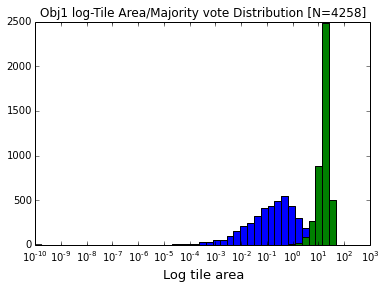

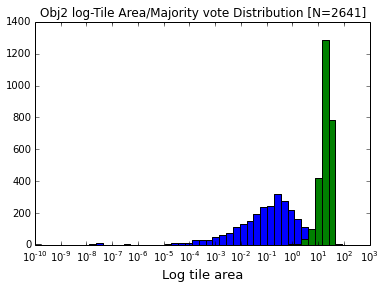

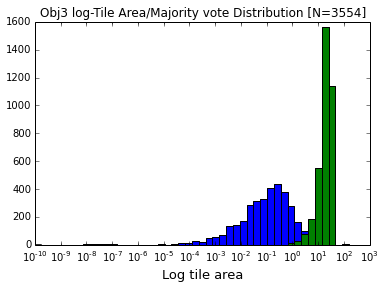

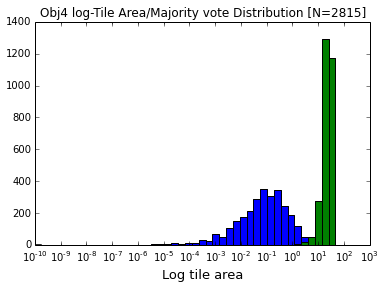

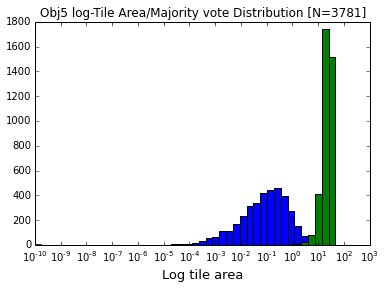

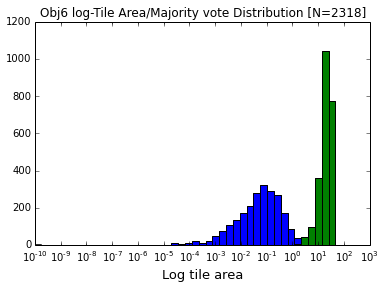

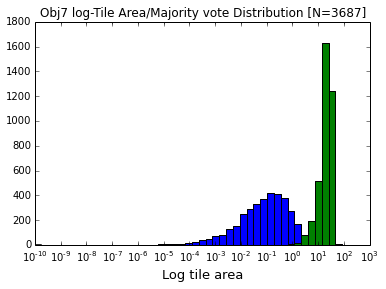

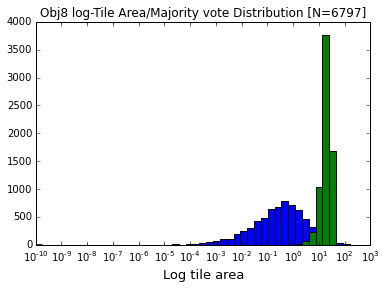

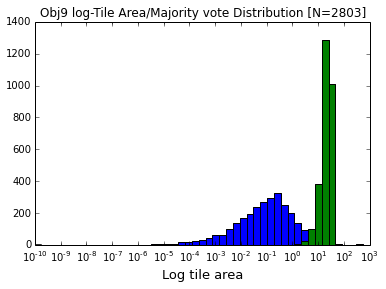

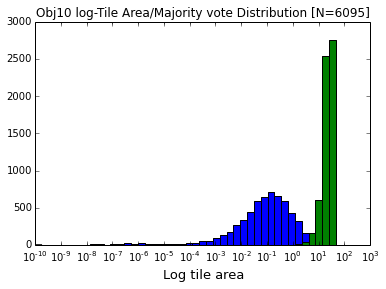

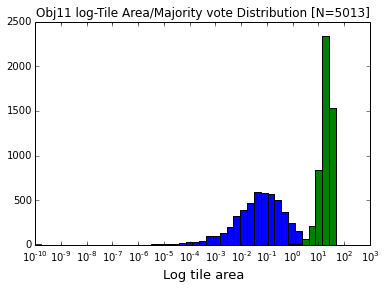

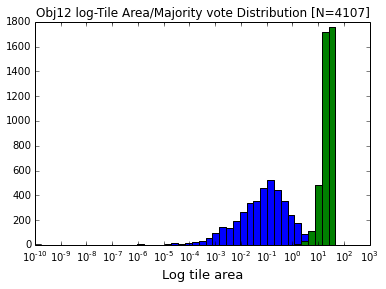

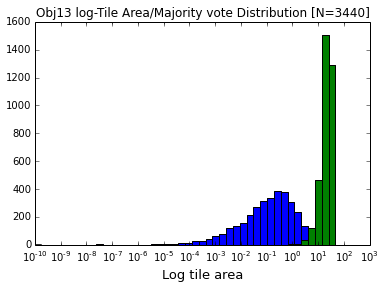

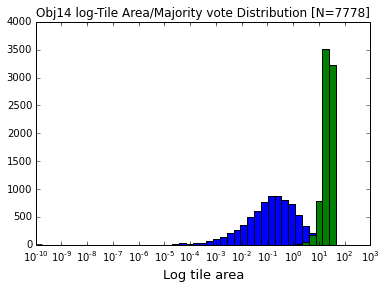

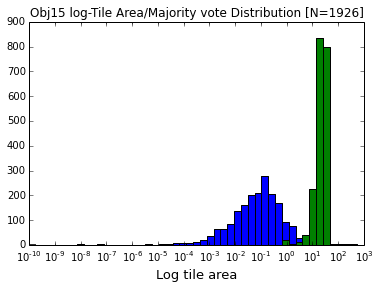

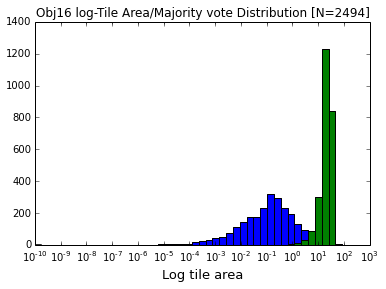

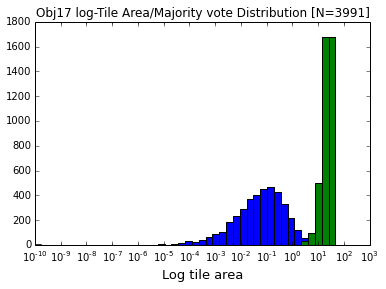

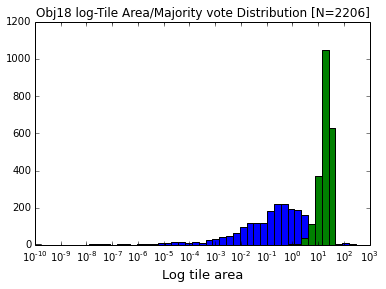

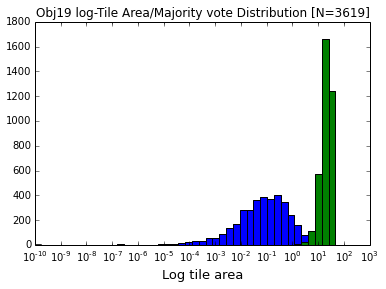

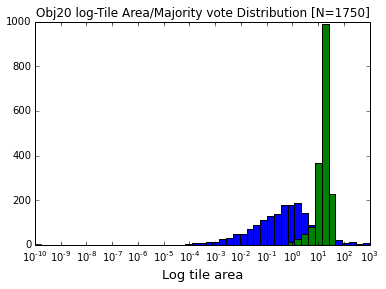

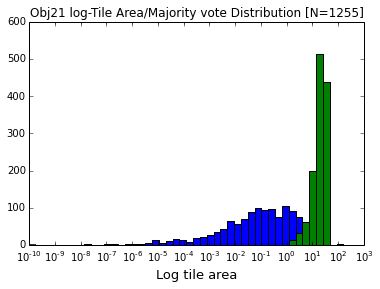

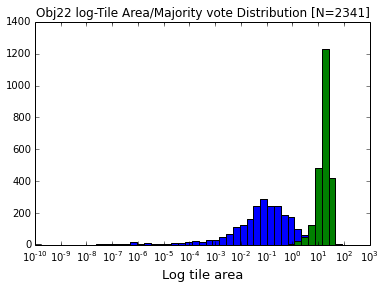

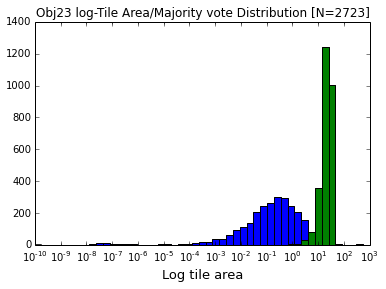

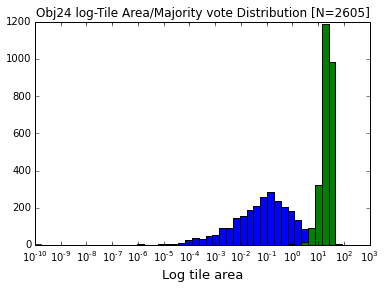

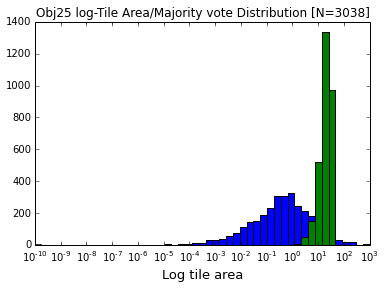

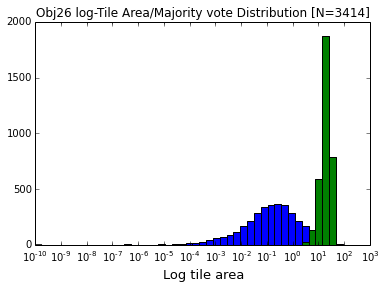

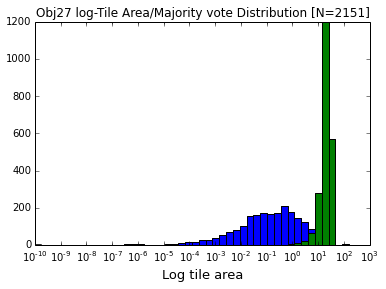

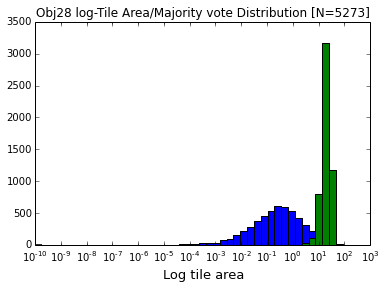

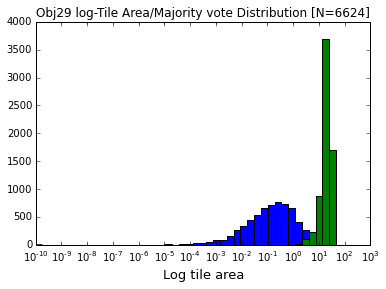

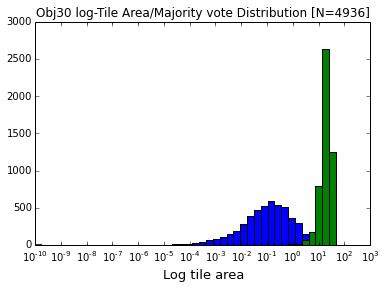

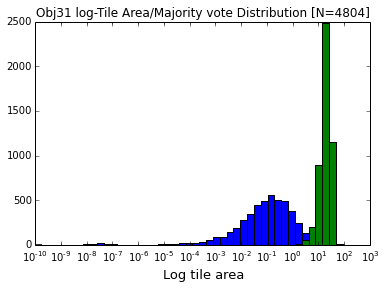

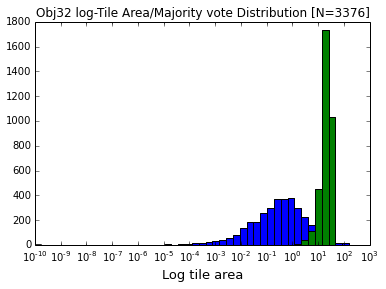

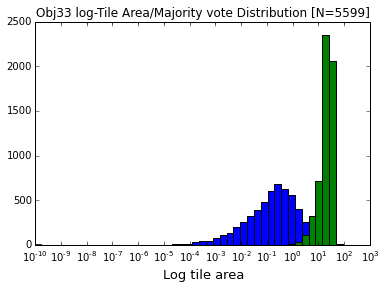

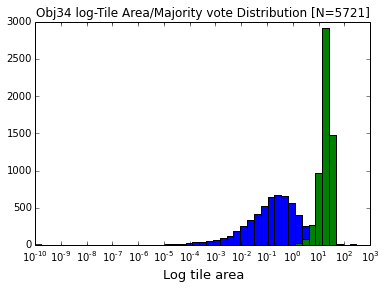

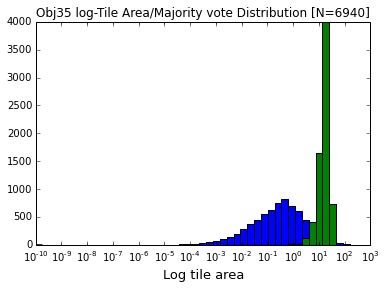

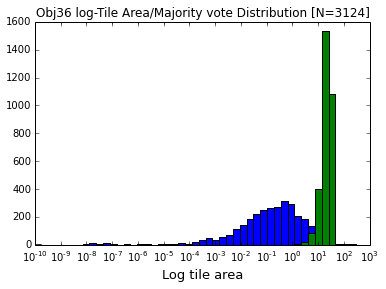

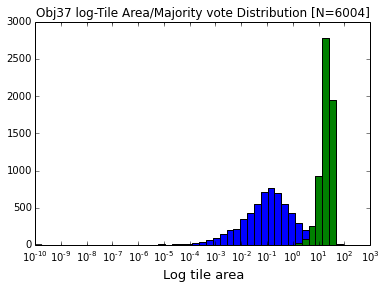

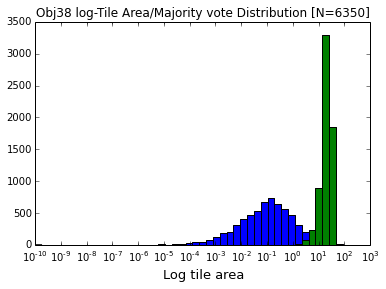

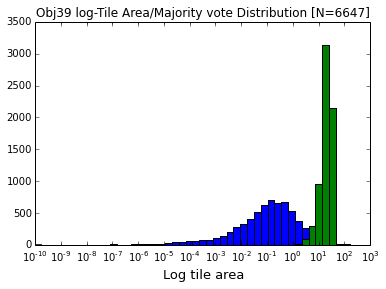

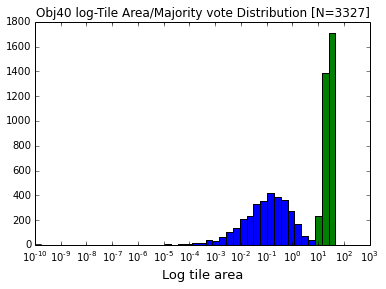

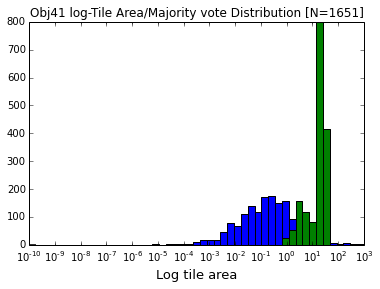

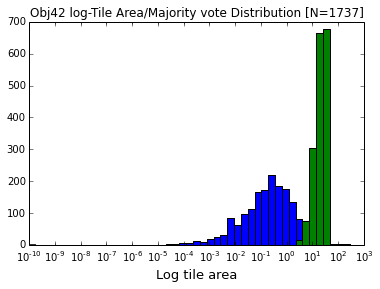

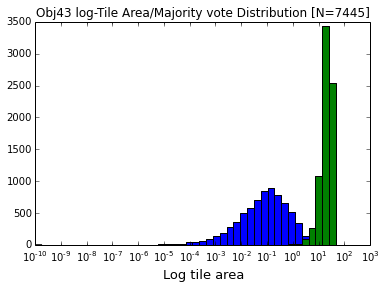

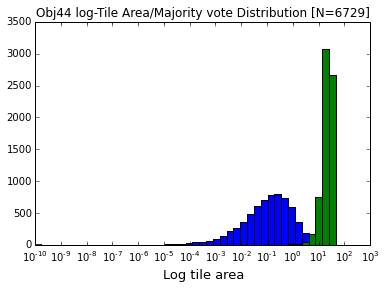

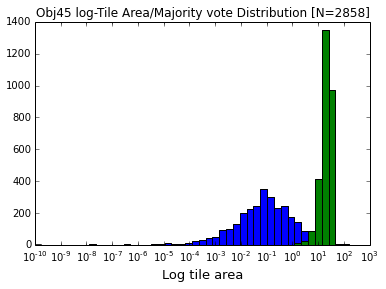

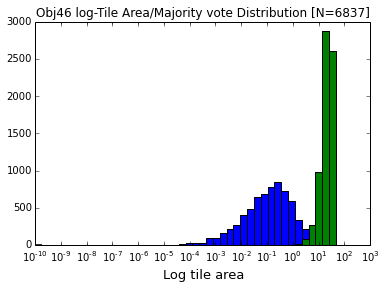

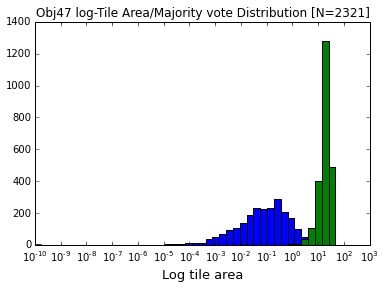

In [17]:
tkArea=[]
tkVotes=[]
for objid in range(1,48):
    indMat  = pkl.load(open("indMat{}.pkl".format(objid)))
    tile_votes=indMat[:-1].sum(axis=0)
    tile_area=indMat[-1]
#     plt.figure()
#     plt.title("Obj {0} [N={1} tiles]".format(objid,len(tiles)))
#     plt.semilogx(tkArea,tkVotes,'.')
#     plt.xlabel("Tile Area",fontsize=13)
#     plt.ylabel("Number of Vot es",fontsize=13)
    plt.figure()
    hist =plt.hist(tile_area, bins=np.logspace(-10, 3, 50))
    hist =plt.hist(tile_votes, bins=np.logspace(-10, 3, 50))
    plt.gca().set_xscale("log")
    plt.title("Obj{0} log-Tile Area/Majority vote Distribution [N={1}]".format(objid,len(tile_area)))
    plt.xlabel("Log tile area",fontsize=13)
#     plt.text(5e-10,max(hist[0])-20,"mean ={:.2f}".format(mean(tile_area)))
#     plt.text(5e-10,max(hist[0])-40,"std ={:.2f}".format(std(tile_area)))

# EM

In [13]:
cd ..

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [15]:
import pandas as pd
from analysis_toolbox import *
from TileEM_plot_toolbox import *
from tqdm import tqdm

In [138]:
def ground_truth_T(object_id):
    my_BBG  = pd.read_csv("my_ground_truth.csv")
    ground_truth_match = my_BBG[my_BBG.object_id==object_id]
    x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    T = Polygon(zip(x_locs,y_locs))
    return T
def estimate_Qj(T,tiles,indMat,workers):
    Qj=[]
    for wid,j in zip(workers,range(len(workers))):
        Qj.append(Qjfunc(indMat,T,j))
    return Qj

In [139]:
def QjBasic(indMat,T,j):
    '''
    Compute MLE of QJ given fixed T=T'for worker j
    '''
    Ncorrect=0
    Nwrong = 0
    for k in range(len(tiles)): 
        tk = tiles[k]
        ljk = indMat[j][k]
        try:
            overlap = T.intersection(tk).area/T.area>0.8
            tjkInT = T.contains(tk) or overlap
        except(shapely.geos.TopologicalError):
            overlap=True
            tjkInT = T.contains(tk)
        if (ljk ==1 and tjkInT) or (ljk ==0 and (not tjkInT)):
            Ncorrect+=1
        elif (ljk ==1 and (not tjkInT)) or (ljk ==0 and tjkInT):
            Nwrong+=1
    qj = Ncorrect/float(Ncorrect+Nwrong)
    return qj

In [140]:
def Tprime_snowball_area(objid,indMat,fixedtopk=5, topk = 40,NTprimes=300):
    tile_area = np.array(indMat[-1])
    # Select majority vote top tiles
    sorted_tidx = tile_area.argsort()[::-1][:topk]
    fixed_tidx = sorted_tidx[:fixedtopk]
    tile_subset_idx =sorted_tidx[fixedtopk:topk]
    #Creating random subsets from topk tiles
    rand_subset =[]
    flexiblek=topk-fixedtopk
    for i in range(NTprimes): 
        NumTilesInCombo= np.random.randint(1,flexiblek)#at least one tile must be selected
        tidxInCombo= list(np.random.choice(tile_subset_idx,NumTilesInCombo,replace=False))
        tidxInCombo.extend(fixed_tidx)
        rand_subset.append(tidxInCombo)
    return rand_subset

In [146]:
def computeT(Tprime_lst,Qj):
    # Loop through Tprime_lst find the argmax T' s.t pTprime is max given fixed Qj
    pTprime_lst =[]
    for Tprime_idx in Tprime_lst:
        pTprime = pTprimefunc(objid,Tprime_idx,Qjhat,T,tiles,indMat,workers)
        pTprime_lst.append(pTprime)
    Tidx= np.argmax(pTprime_lst)
    max_likelihood =pTprime_lst[Tidx]
    return join_tiles(Tprime_lst[Tidx],tiles)[0],max_likelihood

In [116]:
def pTprimeBasic(objid,Tprime,Qj,T,tiles,indMat,workers):
    '''
    Basic Tile EM Worker model 
    Given a tile combination Tprime, compute likelihood of that T'=T
    '''
    plk=[]
    for k in Tprime: 
        for j in range(len(workers)):
            tk = tiles[k]
            ljk = indMat[j][k]
            wid=workers[j]
            tjkInT = T.contains(tk) #overlap > threshold
            qj = Qj[j]
            if (ljk ==1 and tjkInT) or (ljk ==0 and (not tjkInT)):
                plk.append(qj)
            elif (ljk ==1 and (not tjkInT)) or (ljk ==0 and tjkInT):
                plk.append(1-qj)
    pTprime=np.product(plk)
    return pTprime

In [142]:
Tfunc = ground_truth_T # how to get ground truth 
Tprimefunc=Tprime_snowball_area #how to pick T'
pTprimefunc=pTprimeBasic # Model used for computing p(T')
Qjfunc=QjBasic #Model used for estimating Qj parameters
DATA_DIR="final_all_tiles"
objid = 2

In [143]:
tiles = pkl.load(open(DATA_DIR+"/vtiles{}.pkl".format(objid)))
indMat = pkl.load(open(DATA_DIR+"/indMat{}.pkl".format(objid)))
workers = pkl.load(open(DATA_DIR+"/worker{}.pkl".format(objid)))
# Get fixed T (obtained some way)
T = Tfunc(objid)
# E-step : Estimate Qj parameters
Qjhat = estimate_Qj(T,tiles,indMat,workers)

In [147]:
# Some way of getting a set of T' (list of list of tile indices) 
# Non-exhaustively looping through T' combinations
Tprime_lst = Tprimefunc(objid,indMat,fixedtopk=5, topk = 40,NTprimes=100)

In [150]:
# Mstep: Picking the max-likelihood T' 
T, max_likelihood= computeT(Tprime_lst,Qjhat)

In [167]:
def initT(tiles,indMat):
    #In the initial step, we pick T to be the top 5 majority vote tile joined
    votes =indMat[:-1].sum(axis=0)
    tidx = argsort(votes)[::-1][:5]
    return join_tiles(tidx,tiles)[0]

In [168]:
tiles = pkl.load(open(DATA_DIR+"/vtiles{}.pkl".format(objid)))
indMat = pkl.load(open(DATA_DIR+"/indMat{}.pkl".format(objid)))
workers = pkl.load(open(DATA_DIR+"/worker{}.pkl".format(objid)))
likelihood_lst=[]
T_lst = []
for _i in tqdm(range(10)):
    if _i ==0:
        T=initT(tiles,indMat)
    # E-step : Estimate Qj parameters
    Qjhat = estimate_Qj(T,tiles,indMat,workers)
    # Some way of getting a set of T' (list of list of tile indices) 
    # Non-exhaustively looping through T' combinations
    Tprime_lst = Tprimefunc(objid,indMat,fixedtopk=5, topk = 40,NTprimes=100)
    # Mstep: Picking the max-likelihood T' 
    T, max_likelihood= computeT(Tprime_lst,Qjhat)
    likelihood_lst.append(max_likelihood)
    T_lst.append(T)

 90%|█████████ | 9/10 [17:51<01:59,  0.01it/s]ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (186.958 375.792, 187.432 373.309) and LINESTRING (187.468 373.122, 186.958 375.792) at 187.23420488927849 374.3446410561603
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (205.652 308.955, 205.62 308.86) and LINESTRING (208.882 318.647, 202.393 299.18) at 205.62800286231379 308.88400858694138
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (189.452 333.699, 189.187 335.486) and LINESTRING (189.859 330.951, 189.151 335.729) at 189.2701504303958 334.92648459482831
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (194.667 413.667, 200.064 416.299) and LINESTRING (196.545 415.545, 200.064 416.299) at 200.0636942675159 416.29936305732485
ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (187.383 373.565, 187.439 

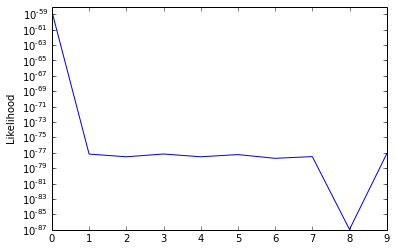

In [174]:
plt.semilogy(likelihood_lst)
plt.ylabel("Likelihood")

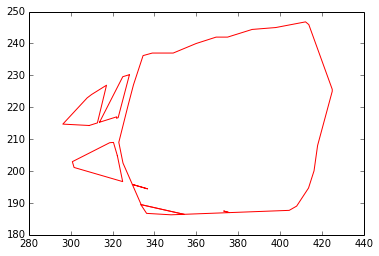

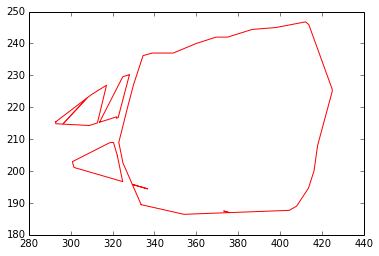

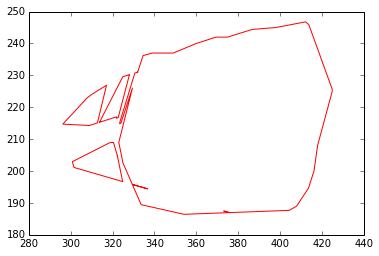

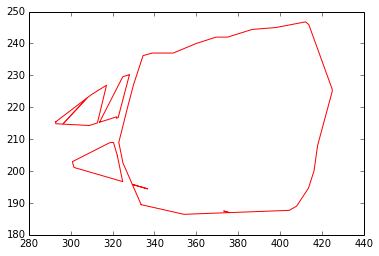

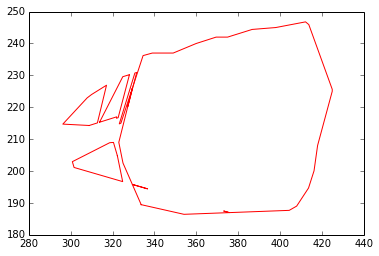

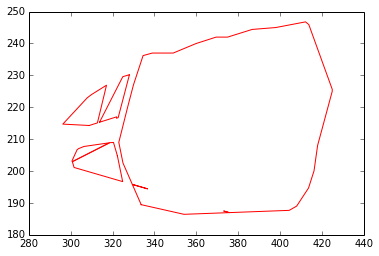

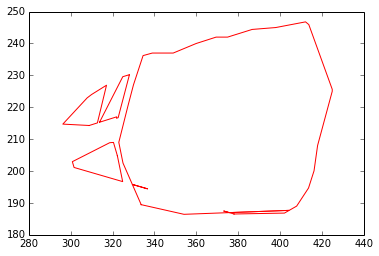

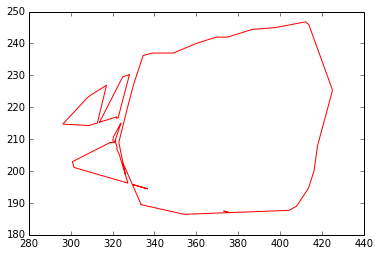

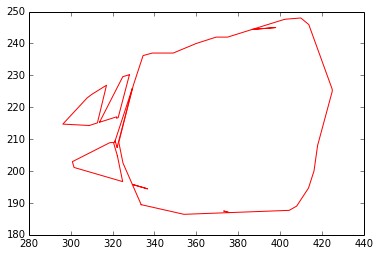

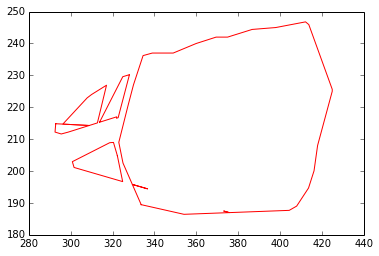

In [176]:
for T in T_lst:
    plt.figure()
    plot_coords(T)

### Pluggable functions for Qjs with multiple values, *kwarg? 

---------------------------------------------------------------------------------------------------

### Check that the results do agree with our previous ones 

In [26]:
worker_qualities = pd.read_csv("final_all_tiles/worker_obj_qualities_all.csv")

In [77]:
print list(worker_qualities[worker_qualities["object_id"]==object_id]["Qj"])

[0.27830367285099999, 0.74290041650900007, 0.70541461567599995, 0.35403256342299999, 0.78152215069999997, 0.78795910639900002, 0.85422188564899992, 0.46611132146899997, 0.60053010223399994, 0.58424839076099999, 0.79023097311599999, 0.518742900417, 0.531616811814, 0.50814085573599999, 0.36425596365000001, 0.54638394547500002, 0.4040136312, 0.426732298372, 0.56077243468400007, 0.56569481257099996, 0.33850814085600006, 0.5959863688, 0.43771298750499998, 0.53502461188899997, 0.51533510034100005, 0.43581976523999999, 0.55887921241999994, 0.80802726240099998, 0.531616811814, 0.7406285497920001, 0.59939416887500008, 0.37107156380199996, 0.53464596743699999, 0.60166603559300003, 0.45967436577100002, 0.52934494509700003]


In [78]:
print Qjhat

[0.27830367285119273, 0.7429004165088982, 0.7054146156758804, 0.35403256342294587, 0.7815221507004922, 0.7879591063990913, 0.8542218856493753, 0.46611132146914047, 0.6005301022340023, 0.5842483907610754, 0.7902309731162438, 0.518742900416509, 0.5316168118137069, 0.5081408557364635, 0.3642559636501325, 0.5463839454751988, 0.4040136312003029, 0.42673229837182886, 0.5607724346838319, 0.5656948125709959, 0.33850814085573644, 0.5959863687996971, 0.43771298750473303, 0.5350246118894358, 0.51533510034078, 0.43581976524043925, 0.5588792124195381, 0.8080272624006059, 0.5316168118137069, 0.7406285497917455, 0.599394168875426, 0.3710715638015903, 0.5346459674365771, 0.6016660355925786, 0.45967436577054144, 0.5293449450965544]
